In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr
import xgcm 
from fastjmd95 import jmd95numba 
import glob
from matplotlib.pyplot import cm


#path
BASE = '/scratch/ab10313/pleiades/'

PATH_LIST_2d = glob.glob(BASE+'*_smooth/2d_data/')
PATH_LIST_3d = glob.glob(BASE+'*_smooth/3d_data/')
PATH_LIST_PP = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [2]:
PATH_LIST_PP

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/08_kuroshio_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/06_california_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [35]:
import submeso_ml.data.dataset as dataset

submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'],res='1_4')
test_ind = submeso_dataset.test_ind

In [36]:
test_ind

array([1658, 2000, 2530, ..., 1428, 4385,  857])

In [3]:
# sort by latitude

lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')

for i_lat in range(12):
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]

In [4]:

label_list = ['Arabian Sea','Agulhas Current', 'New Zealand', 'Kuroshio Current', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific', 'California Current','Indian Ocean' ]

In [5]:
def load_data(var_name_string,time_window=15,coarsen_factor=12):
    PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/'+var_name_string+'.nc')
    data_0 = xr.open_dataarray(PATH_LIST[0])
    data_app = data_0.values
    #print(PATH_LIST[0])
    #print(data_app)
    for i_file in np.arange(1,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH)
        data_app = np.concatenate((data_app,data),axis=0)
        #print(PATH_LIST[i_file])
        #print(data_app)
    return data_app

In [6]:
# calculate wavenumber equivalent for resolution for each latitute 
earth_rad_km = 6371.0072
res_arr = [1/12,1/8,1/4,1/2,1]
res_wavenum = np.empty((len(PATH_LIST),5))

for i_lat in range(len(PATH_LIST)):
    PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
    lat_rad = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()*np.pi/180
    for i_res in range(5):
        lat_rad_m_res =  lat_rad - res_arr[i_res]*np.pi/180
        
        #res_km = np.abs(2*np.pi*earth_rad_km*(np.sin(lat_box)-np.sin(lat_box_m_res)))
        distance_radians = 2*np.arcsin(np.sqrt((np.sin((lat_rad-lat_rad_m_res)/2))**2))
        distance_km = earth_rad_km * distance_radians
        
        #res_km = np.abs(2*np.pi*earth_rad_km*(np.arccos(np.sin(lat_rad)*np.sin(lat_box_m_res))))
        
        #distance_km = radius_km * distance_radians 
        
        
        
        res_wavenum[i_lat,i_res] = 1/distance_km

In [7]:
res_wavenum

array([[0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321],
       [0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321]])

In [8]:
res_wavenum[3,:]


array([0.10791847, 0.07194565, 0.03597282, 0.01798641, 0.00899321])

In [9]:
k_r_max_mld = load_data('k_r_max_mld')

In [10]:
k_r_max_mld

array([0.00399514, 0.07063466, 0.07295088, 0.04760941, 0.02468018,
       0.00396205, 0.06086825, 0.07311192, 0.00959859, 0.08177656,
       0.02271331])

In [11]:
WB_kr_cross_spectra_mld = load_data('WB_kr_cross_spectra_mld')

In [12]:
WB_kr_cross_spectra_mld_rs = np.reshape(WB_kr_cross_spectra_mld,(len(PATH_LIST_PP),120))

In [13]:
WB_kr_cross_spectra_mld.shape

(1440,)

In [14]:
WB_kr_cross_spectra_mld_rs.shape

(12, 120)

In [15]:
ds_T = xr.open_dataset(PATH_LIST_3d[6]+'ds_T.nc',engine="h5netcdf")
HML = xr.open_dataarray(PATH_LIST_PP[6]+'HML.nc',engine="h5netcdf")

dx = ds_T.dxF.mean()
WB_cross_spectra = xr.open_dataarray(PATH_LIST_PP[6]+'WB_cross_spectra_z.nc')
k_r = WB_cross_spectra.freq_r/dx/1e-3

In [16]:
dx.values

array(1688.9769, dtype=float32)

In [ ]:
# sort by latitude

lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0

for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]


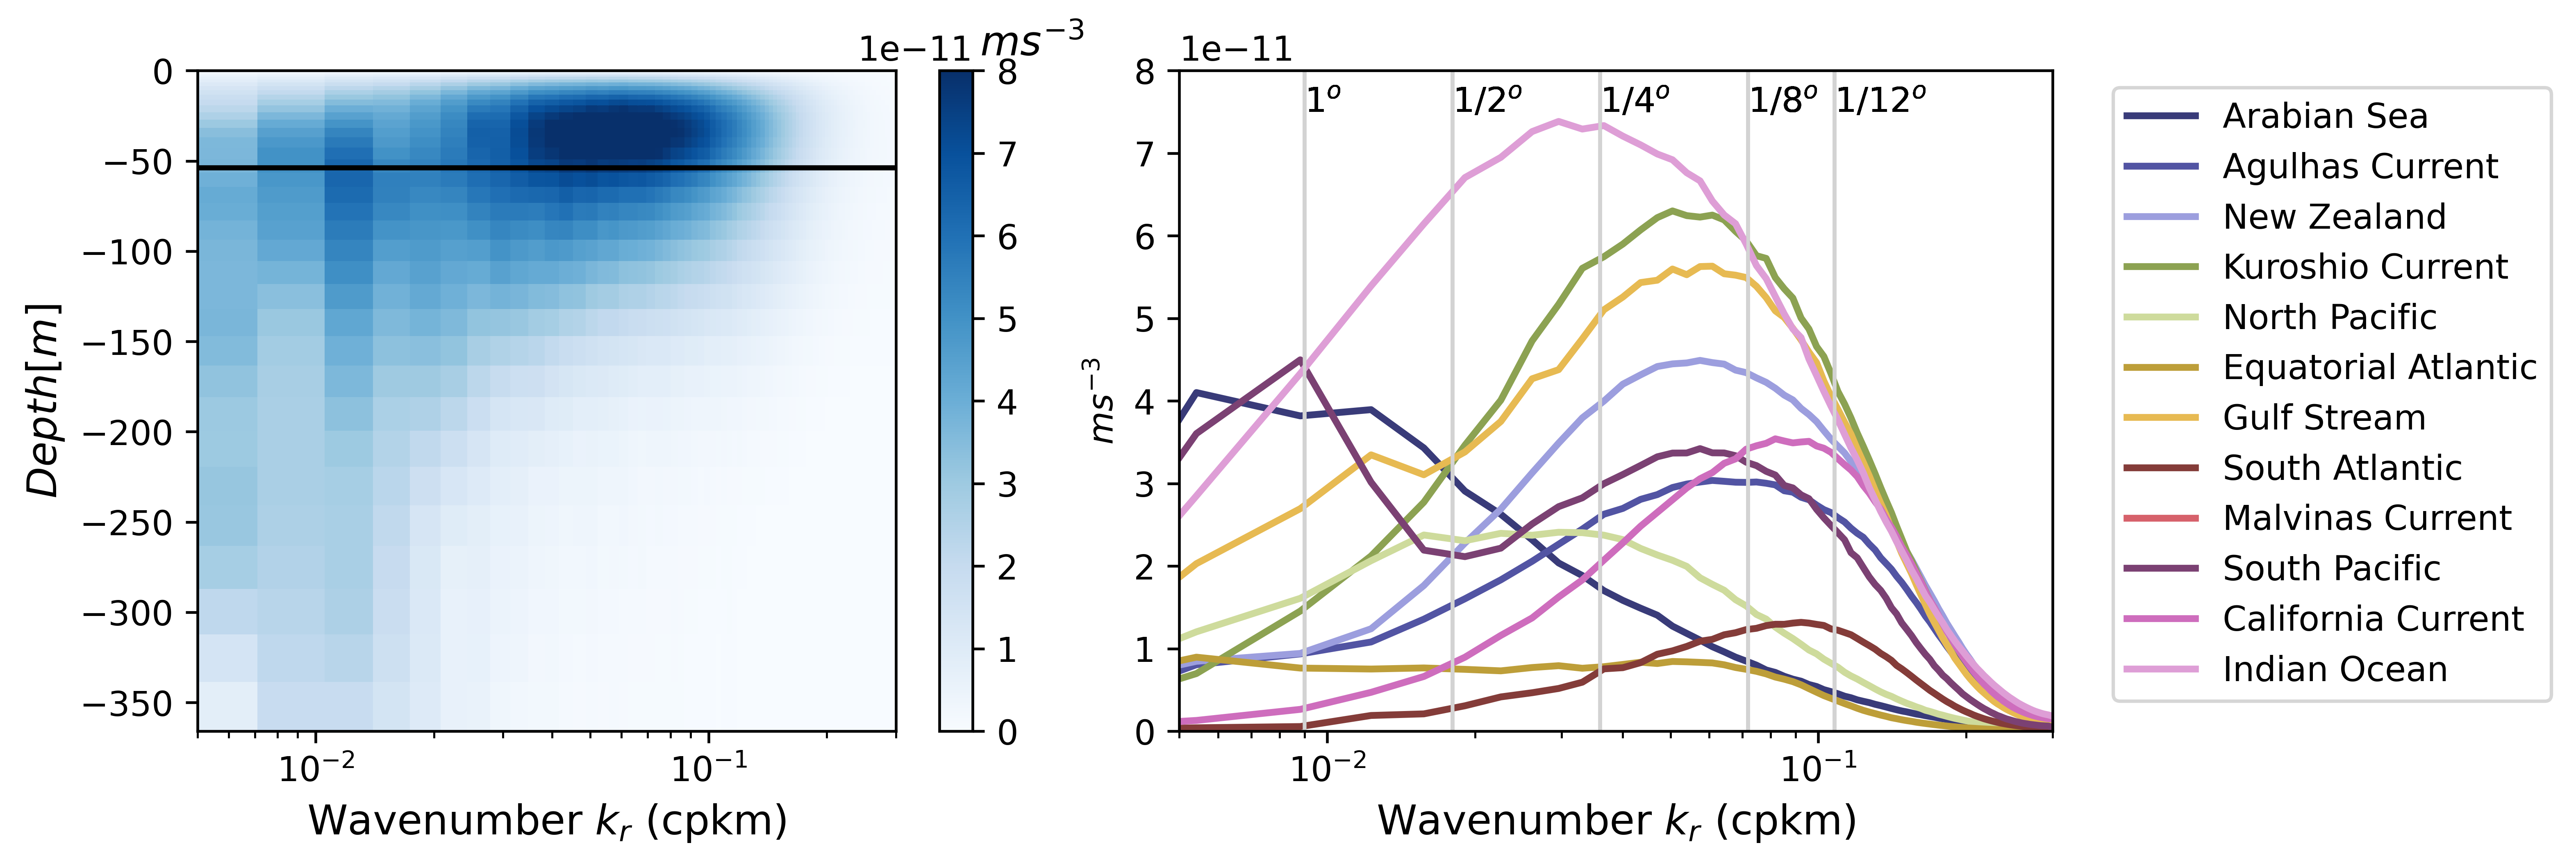

In [34]:
PATH_LIST = glob.glob(BASE+'*/preprcossed_data/WB_kr_cross_spectra_mld.nc') 

label_list = ['Arabian Sea','Agulhas Current', 'New Zealand', 'Kuroshio Current', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific', 'California Current','Indian Ocean' ]


#cmap='Paired'
color = cm.tab20b(np.linspace(0, 1, 12))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), dpi=600)
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.tight_layout(pad=0.1)

plt.subplot(122)
for i_file, c_loc in zip(range(12),color): 
    plt.plot(k_r,WB_kr_cross_spectra_mld_rs[i_file,:],color=c_loc, linewidth=2,label=label_list[i_file]);
#     plt.scatter(res_wavenum[i_file,0],
#                 WB_kr_cross_spectra_mld_rs[i_file,np.absolute(k_r-res_wavenum[i_file,0]).argmin()],c='purple',s=100,marker='*')
#     plt.scatter(res_wavenum[i_file,1],
#                 WB_kr_cross_spectra_mld_rs[i_file,np.absolute(k_r-res_wavenum[i_file,1]).argmin()],c='magenta',s=100,marker='*')
#     plt.scatter(res_wavenum[i_file,2],
#                 WB_kr_cross_spectra_mld_rs[i_file,np.absolute(k_r-res_wavenum[i_file,2]).argmin()],c='k',s=100,marker='*')
#     plt.scatter(res_wavenum[i_file,3],
#                 WB_kr_cross_spectra_mld_rs[i_file,np.absolute(k_r-res_wavenum[i_file,3]).argmin()],c='green',s=100,marker='*')
#     plt.scatter(res_wavenum[i_file,4],
#                 WB_kr_cross_spectra_mld_rs[i_file,np.absolute(k_r-res_wavenum[i_file,4]).argmin()],c='blue',s=100,marker='*')

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xscale("log")
    plt.ylim([0,8e-11])
    plt.xlim([5e-3,3e-1])
    plt.xlabel(r'Wavenumber $k_r$ (cpkm)',fontsize=12)
    plt.ylabel('$m s^{-3}$')
    plt.vlines(res_wavenum[0,0],0,1,colors='lightgrey',linewidth=1)
    plt.text(res_wavenum[0,0],7.5e-11,r'$1/12^o$')
    plt.vlines(res_wavenum[0,1],0,1,colors='lightgrey',linewidth=1)
    plt.text(res_wavenum[0,1],7.5e-11,r'$1/8^o$')
    plt.vlines(res_wavenum[0,2],0,1,colors='lightgrey',linewidth=1)
    plt.text(res_wavenum[0,2],7.5e-11,r'$1/4^o$')
    plt.vlines(res_wavenum[0,3],0,1,colors='lightgrey',linewidth=1)
    plt.text(res_wavenum[0,3],7.5e-11,r'$1/2^o$')
    plt.vlines(res_wavenum[0,4],0,1,colors='lightgrey',linewidth=1)
    plt.text(res_wavenum[0,4],7.5e-11,r'$1^o$')
    #plt.title('Variance-preserving $\overline{wb}^z$ cross-spectrum')
    #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    
plt.subplot(121)
plt.pcolor(k_r, ds_T.Z[:35], WB_cross_spectra.real[:35,:]*k_r, cmap='Blues',vmin=0, vmax=8e-11)
plt.axhline(HML.mean().values,color = 'k', linestyle = '-')
plt.xscale("log")
plt.xlabel(r'Wavenumber $k_r$ (cpkm)',fontsize=12)
plt.ylabel(r'$Depth [m]$',fontsize=12)
plt.xlim([5e-3,3e-1])
cbar =plt.colorbar()
cbar.set_label('$m s^{-3}$',fontsize=12,y=1.07, rotation=0)
#plt.title('Variance-preserving '+ r'$wb$' +' cross-spectrum', fontsize=10)

#plt.subplots_adjust(bottom=0.025)
plt.savefig('./figures/wb_cospectrum', bbox_inches='tight')
#plt.savefig('./figures/wb_cospectrum_trans', bbox_inches='tight', transparent=True)